<a href="https://colab.research.google.com/github/simonlee2216/roomify/blob/main/dreambedroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio
!pip install diffusers transformers pillow
!pip install sentence-transformers scikit-learn
!pip install flask
!pip install gradio
!pip install pyngrok
!pip install ultralytics

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

# Load the Model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

# Get User Input
prompt = input("Enter a description of your dream living room: ")

# Example default prompt in case user does not input anything
if not prompt:
    prompt = "A cozy living room with a large window overlooking a forest, comfortable sofa, fireplace, plants, and bookshelves."

# Generate the Image
image = pipeline(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]

image.show()  # or simply `image` in a cell to show it inline
image.save("dream_living_room.png")

In [ ]:
!pip install diffusers transformers torch pillow

In [3]:
import torch
import pickle
from PIL import Image
import numpy as np
from diffusers import StableDiffusionPipeline
import io
import base64
from flask import Flask, request, jsonify, render_template
import gradio as gr
from pyngrok import ngrok
import subprocess
import tempfile
 # Imports for object detection (YOLOv8 in this example)
import torch
import cv2
import time
import base64
import io

In [8]:
from ultralytics import YOLO


# Load Stable Diffusion Model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")


# Load object detection model
try:
    model = YOLO("yolov8s.pt").to("cuda")
    print("YOLOv8s model loaded successfully using ultralytics library")
except Exception as e:
    print(f"Error loading YOLOv8 model using ultralytics library: {e}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 21.5M/21.5M [00:00<00:00, 239MB/s]


YOLOv8s model loaded successfully using ultralytics library


In [ ]:
previous_image = None

In [4]:
def base64_to_image(base64_str):
    image_data = base64.b64decode(base64_str)
    image_buffer = io.BytesIO(image_data)
    image = Image.open(image_buffer).convert("RGB")
    return np.array(image)

In [19]:
def generate_image(prompt):
    global previous_image

    image = pipeline(prompt, num_inference_steps=200, guidance_scale=8.5).images[0]
    previous_image = image
    with tempfile.NamedTemporaryFile(suffix=".png", delete = False) as tmp_file:
       image.save(tmp_file.name)
    return tmp_file.name # returns a string representing the file path

In [6]:
from diffusers.pipelines.stable_diffusion import safety_checker

def sc(self, clip_input, images) : return images, [False for i in images]

# edit the StableDiffusionSafetyChecker class so that, when called, it just returns the images and an array of True values
safety_checker.StableDiffusionSafetyChecker.forward = sc

  0%|          | 0/200 [00:00<?, ?it/s]

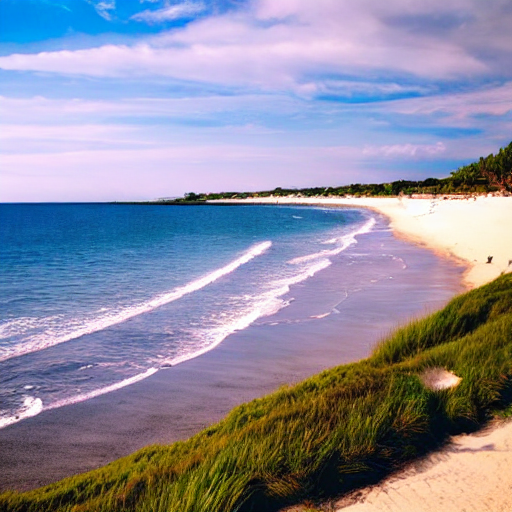

In [32]:
prompt = "a very nice view of a beach"
test_image_base64 = generate_image(prompt)

with open(test_image_base64, "rb") as image_file:
    image_data_bytes = image_file.read()
    test_image_base64 = base64.b64encode(image_data_bytes).decode("utf-8")
# Convert the base64 string to a PIL image
image_data = base64.b64decode(test_image_base64)
image_buffer = io.BytesIO(image_data)
image = Image.open(image_buffer)


# Display the image
image

In [ ]:
def refine_image(prompt):
    global previous_image
    if previous_image is None:
      return "No previous image, please generate an initial image first"

    image = pipeline(prompt, image=previous_image, num_inference_steps=50, guidance_scale=7.5).images[0]
    previous_image = image
    with tempfile.NamedTemporaryFile(suffix=".png", delete = False) as tmp_file:
       image.save(tmp_file.name)
    return tmp_file.name # returns a string representing the file path

In [ ]:
def remove_object(image, x1, y1, x2, y2):
  global previous_image
  if previous_image is None:
      return "No previous image, please generate an initial image first."
  buffered = io.BytesIO()
  image.save(buffered, format="JPEG")
  img_str = base64.b64encode(buffered.getvalue()).decode()

  if not img_str:
      return "No base64 image found"
  box = [x1, y1, x2, y2]
  if not box:
      return "No bounding box given"

  image_np = base64_to_image(img_str)

  #Run inference with the model
  results = model(image_np)
  #Check for detections
  # Apply the mask to create a mask
  mask = np.zeros_like(image_np[:, :, 0], dtype=np.float32)
  mask[int(y1):int(y2), int(x1):int(x2)] = 1.0
  # Convert back to PIL image
  mask_image = Image.fromarray((mask*255).astype(np.uint8))
  #Use Stable Diffusion Inpainting
  prompt = "remove this object from the image"
  image = pipeline(prompt=prompt, image=previous_image, mask_image = mask_image, num_inference_steps=50, guidance_scale=7.5).images[0]
  previous_image = image
  with tempfile.NamedTemporaryFile(suffix=".png", delete = False) as tmp_file:
      image.save(tmp_file.name)
  return tmp_file.name # returns a string representing the file path

In [ ]:
iface = gr.Interface(
      fn=generate_image,
      inputs=gr.Textbox(label="Enter Prompt for Initial Image"),
      outputs=gr.Image(label="Generated Image")
     )
refine_interface = gr.Interface(
        fn=refine_image,
        inputs=gr.Textbox(label="Enter text for refining the image"),
        outputs=gr.Image(label="Refined Image"),
     )

remove_interface = gr.Interface(
        fn = remove_object,
        inputs=[
            gr.Image(label="Select image"),
            gr.Number(label="x1"),
            gr.Number(label="y1"),
            gr.Number(label="x2"),
            gr.Number(label="y2")
          ],
        outputs=gr.Image(label="Refined Image")
     )


demo = gr.TabbedInterface([iface, refine_interface, remove_interface], ["Initial Image", "Refined Image", "Remove Object"]).launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9b023ee6182131923b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/50 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2044, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1591, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
           ^^^^^^^^^^

  0%|          | 0/50 [00:00<?, ?it/s]

Using existing dataset file at: .gradio/flagged/dataset1.csv


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7866 <> https://9b023ee6182131923b.gradio.live
